Importação e SetUp

In [1]:
# Importação de bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import joblib

#Random seed para reprodutibilidade
RANDOM_STATE =42
np.random.seed(RANDOM_STATE)

Extraction and load

In [45]:
#####EXTRACTION
KAGGLE_DATASET = "kaverappa/amazon-best-seller-softwares"
DATASETS_PATH = kagglehub.dataset_download("kaverappa/amazon-best-seller-softwares")


#####LOAD
def load_abss_data(dataset_path=DATASETS_PATH, filename="best_sellers_data2.csv"):
    csv_path = os.path.join(dataset_path, filename)
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"arquivo nao encontrado no path")
    return pd.read_csv(csv_path)

df=load_abss_data()

Tratamento

In [46]:
## Verificando os dados
print(df.head())
print('\n')
print(df.describe())
print('\n')
print(df.info())

#Limpeza de dados incluindo: transformação dos preços em numeric, remoção de duplicatas e de valores nulos
def clean_data(df):
    df['product_price']= df['product_price'].replace({'\$': '', ',':''}, regex=True)
    df['product_price'] = pd.to_numeric(df['product_price'], errors='coerce')
    print('\n','Null Count:',df.isnull().sum())
    df.dropna(subset=['product_price', 'product_star_rating', 'product_num_ratings'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['country'] = df['country'].astype('category')
    
    return df
#Garantindo que os dados estão limpos e prontos para uso
print('\nPos-limpeza info dos dados:')
print(df.info())
df= clean_data(df)

                                       product_title product_price  \
0  TurboTax Deluxe 2024 Tax Software, Federal & S...        $55.99   
1  TurboTax Premier 2024 Tax Software, Federal & ...        $82.99   
2  TurboTax Home & Business 2024 Tax Software, Fe...        $95.99   
3  TurboTax Business 2024 Tax Software, Federal T...       $143.99   
4  H&R Block Tax Software Deluxe + State 2024 wit...        $49.97   

   product_star_rating  product_num_ratings  rank country  
0                  4.2               6511.0     1      US  
1                  4.1               2738.0     2      US  
2                  4.2               1672.0     3      US  
3                  4.0                389.0     4      US  
4                  3.9               1683.0     5      US  


       product_star_rating  product_num_ratings         rank
count          2270.000000          2066.000000  2423.000000
mean              4.101718          1254.898354    50.113908
std               0.580566        

<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
C:\Users\clara\AppData\Local\Temp\ipykernel_27312\2862431801.py:10: SyntaxWarning: invalid escape sequence '\$'
  df['product_price']= df['product_price'].replace({'\$': '', ',':''}, regex=True)


Análise exploratória e mudanças necessárias

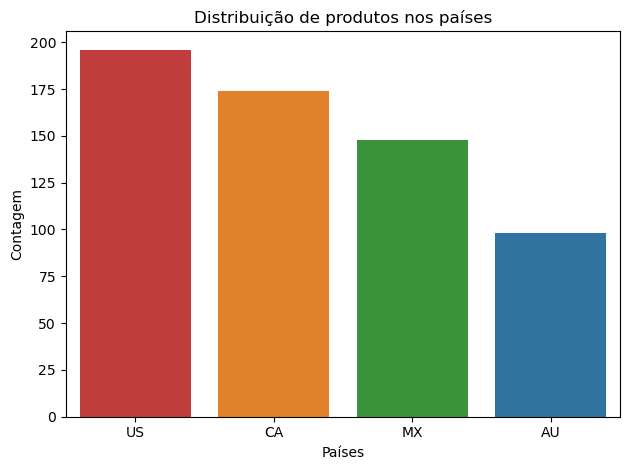

In [ ]:
#1. Count plot: Distribuição dos produtos por pais
c_plot = sns.countplot(data= df, x='country',hue='country' ,order=df['country'].value_counts().index)
plt.title('Distribuição de produtos nos países')
plt.xlabel('Países')
plt.ylabel('Contagem')
plt.tight_layout()
plt.show()

###Nesse gráfico foi gerado apenas para entender de onde a maior parte dos produtos vem, nesse caso, dos EUA.

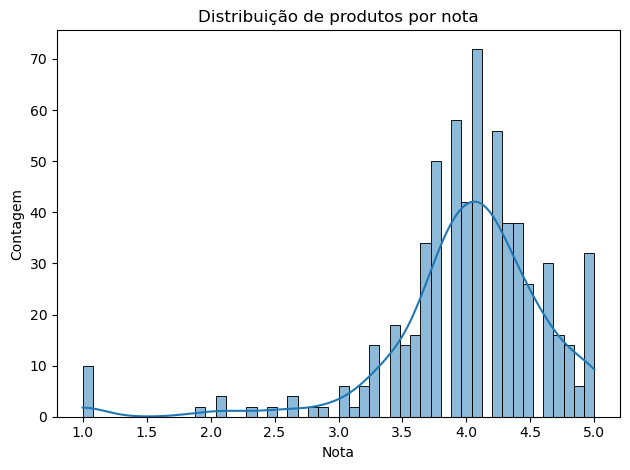

In [48]:
#2. Histograma: Distribuição dos produtos por nota
h_plot = sns.histplot(data=df, x='product_star_rating',bins=50, kde=True)
plt.title('Distribuição de produtos por nota')
plt.xlabel('Nota')
plt.ylabel('Contagem')
plt.tight_layout()
plt.show()

###Nesse gráfico foi gerado para entender a distribuição das notas dos produtos, onde a maioria dos produtos tem notas entre 4 e 5 estrelas.

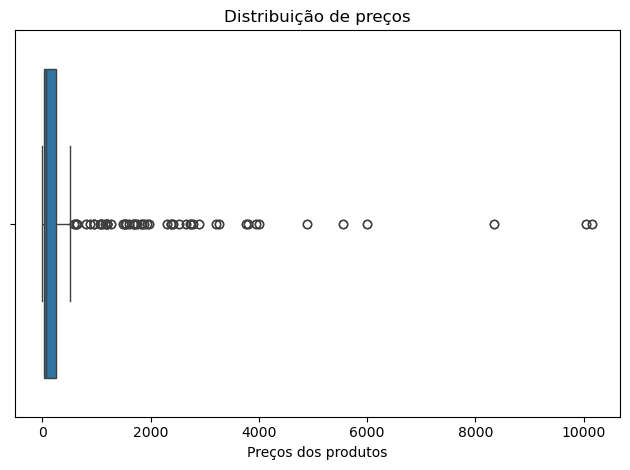

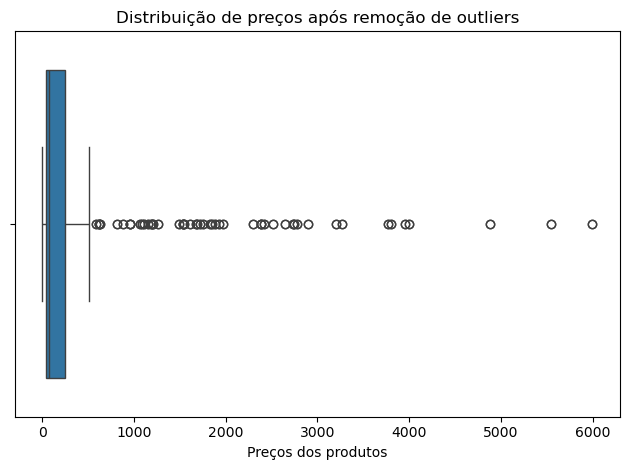

In [49]:
#3. Box plot: Distribuição dos preços para identificar outliers
b_plot = sns.boxplot(data=df, x='product_price')
plt.title('Distribuição de preços')
plt.xlabel('Preços dos produtos')
plt.tight_layout()
plt.show()

p99 = df['product_price'].quantile(0.99)
df=df[df['product_price']<=p99]

#3.1 Box plot: Distribuição dos preços após remoção de outliers
b_plot = sns.boxplot(data=df, x='product_price')
plt.title('Distribuição de preços após remoção de outliers')
plt.xlabel('Preços dos produtos')
plt.tight_layout()
plt.show() 


# Esse gráfico demonstra que a maioria dos produtos (representados pela barra azul) estão entre 0 e 200 dolares. 
# No entanto, é possível notar uma quantidade de grande de outliers até 6000 dólares que não devem ser ignorados, por isso, a técnica de limpeza desses dados foi a de percentile 99. 
# Dessa forma, garantindo que seriam eliminados apenas os produtos que realmente tivessem uma quantiade pequena. 

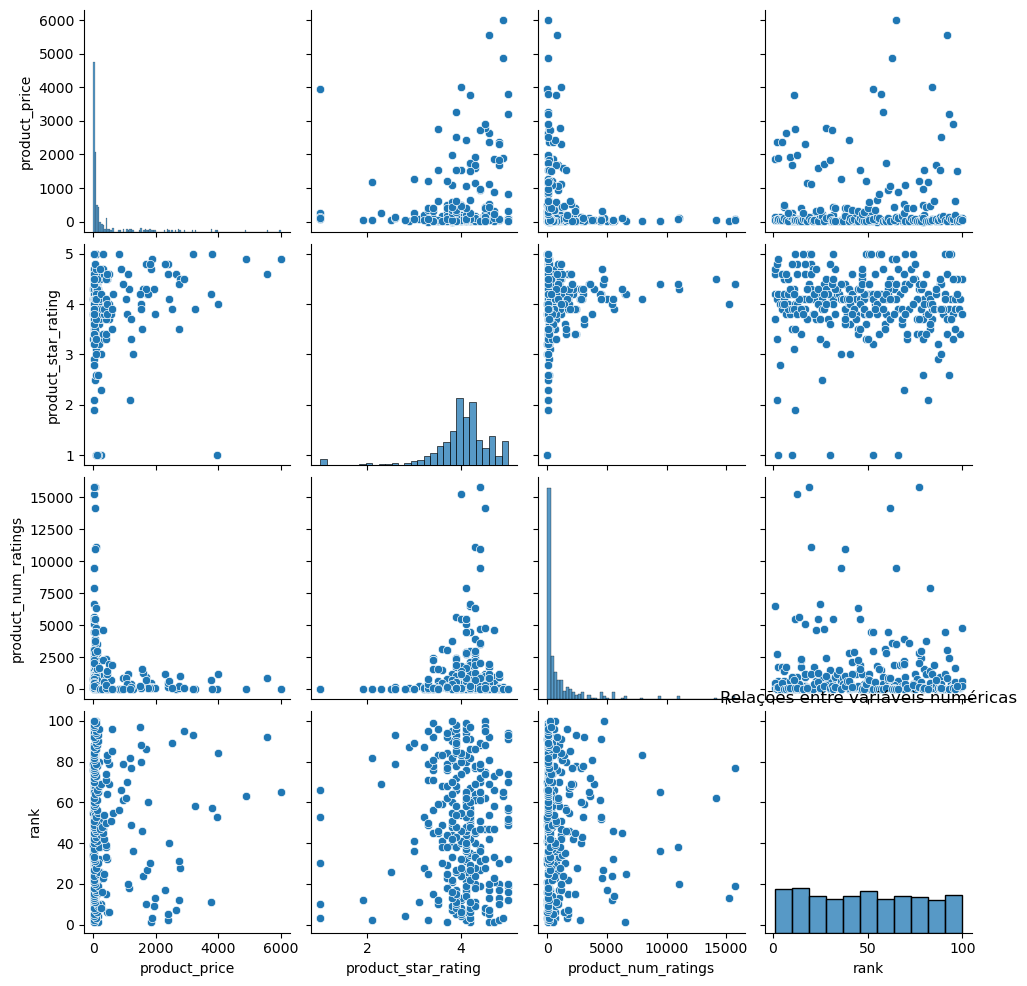

In [73]:
#4. Pair plot: Relações entre variaveis numéricas
p_plot = sns.pairplot(df[['product_price', 'product_star_rating', 'product_num_ratings', 'rank']])
plt.title('Relações entre variáveis numéricas')
plt.show()

# Esse gráfico mostra a relação entre as variáveis numéricas, assim sendo possível notar que a maioria dos produtos com preço mais baixo tem uma quantidade maior de estrelas e de avaliações.
# Assim, é possível notar que os produtos mais caros não necessariamente vistos como melhores pelo público, já que, apesar de terem otimas avaliações, os produtos mais baratos também são bem avaliados.

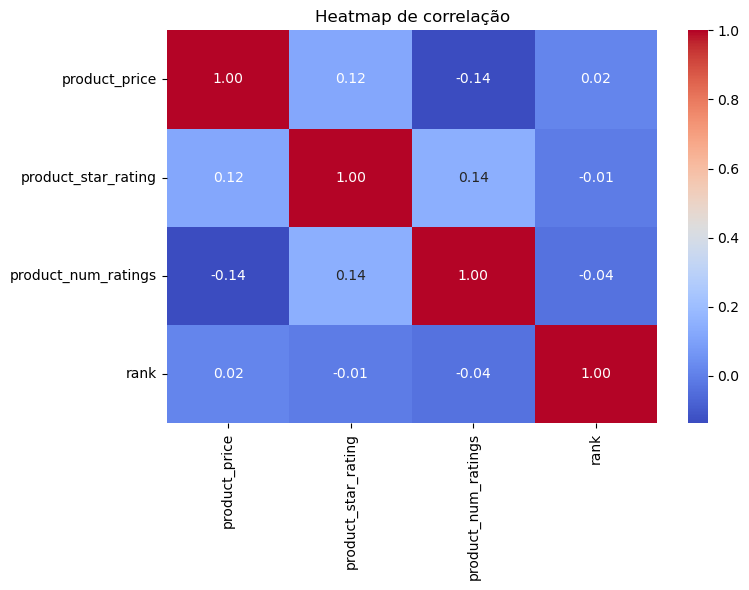

In [51]:
#5. Heatmap de correlação: Apenas se tiver +4 colunas numéricas
numeric_df= df.select_dtypes(include=[np.number])
if numeric_df.shape[1]>=4:
    plt.figure(figsize=(8,6))
    corr = numeric_df.corr()
    sns.heatmap(data=corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Heatmap de correlação')
    plt.tight_layout()
    plt.show()
else:
    print("Sem colunas numericas suficientes")

# Nesse gráfico é possível notar que a variável 'product_star_rating' tem uma correlação positiva com 'product_num_ratings' e 'rank', o que indica que produtos com mais avaliações tendem a ter uma classificação mais alta.
# Além disso, a variável 'product_price' tem uma correlação negativa com 'product_star_rating', o que sugere que produtos mais caros não necessariamente são melhor avaliados.
# Assim, sendo um indicativo que o preço não é o único fator que influencia a avaliação dos produtos, sendo possível que características como qualidade, marca e funcionalidade também desempenhem um papel importante na percepção dos consumidores.
# Por fim, as variáveis não apresentam uma correlação muito forte entre si, o que sugere que cada uma delas traz informações distintas sobre os produtos.

Teste de modelos de predição

In [52]:
#Dividindo as features, target e o dataset em treino e teste
#Features e target
features = ['product_star_rating', 'product_num_ratings', 'rank']
target = 'product_price'

X= df[features]
y= df[target]

#Treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=RANDOM_STATE)


Erro quadrático médio: 974.3127652515747

 RMSE lin reg: [ 770.54687429  710.96653171  841.64779929 1244.21778598  702.32840489
  494.15743731 1159.44271913  828.97500108  712.67208684  956.6373465 ]

 R2 lin reg: 0.044212064601315215


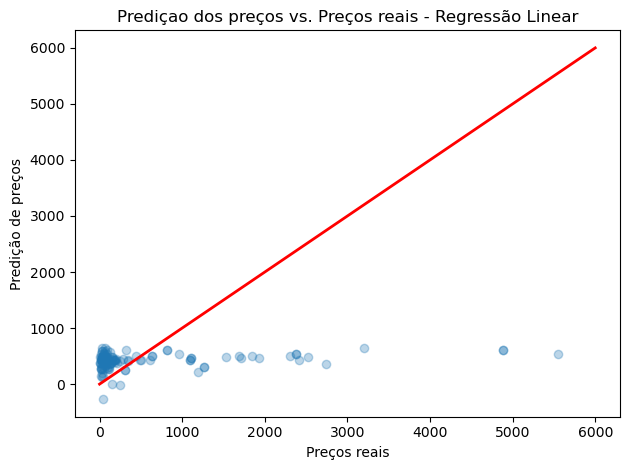

In [53]:
## Modelo de regressão linear
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
price_pred1= lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, price_pred1)
lin_rmse = np.sqrt(lin_mse)
print('\nErro quadrático médio:', lin_rmse) 
# O erro quadrático médio é uma métrica para entender o desempenho do modelo, onde quanto menor o valor, melhor o modelo.
# Nesse caso, o modelo de regressão linear teve um erro quadrático médio de $974 dólares, indicando que ele não é um bom modelo para prever o preço dos produtos, já que 
# o preço dos produtos varia entre 0 e 6000 dólares.

#Cross-validation: Regressão linear
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lin_rsme_scores = np.sqrt(-lin_scores)
print('\n', 'RMSE lin reg:',lin_rsme_scores)
lin_r2 = r2_score(y_test, price_pred1)
print('\n', 'R2 lin reg:',lin_r2)
# Como era de se esperar pelo RMSE apresentado anteriormente, o R2 também não é bom, cerca de 4,42% ,já que o modelo não consegue explicar a variabilidade dos dados.

#Scatter plot: prediçoes vs. preços reais - Regressão linear
plt.scatter(x=y_test, y=price_pred1, alpha=0.3)
plt.title('Prediçao dos preços vs. Preços reais - Regressão Linear')
plt.xlabel('Preços reais')
plt.ylabel('Predição de preços')
plt.plot([y.min(), y.max()], [y.min(), y.max()],color='red', lw=2)
plt.tight_layout()
plt.show()
# O gráfico nos mostra visualmente que os preços reais e as predições do modelo de regressão linear estão muito distantes do que se deseja. 


Erro quadrático médio: 505.75974697219334

 RMSE tree reg: [ 441.15519627  492.07172921  254.64728346 1014.51666799  445.66166485
  259.03355385  481.12131244  641.98453071  244.85421214  517.1639321 ]

 R2 tree reg: 0.7424549059586638


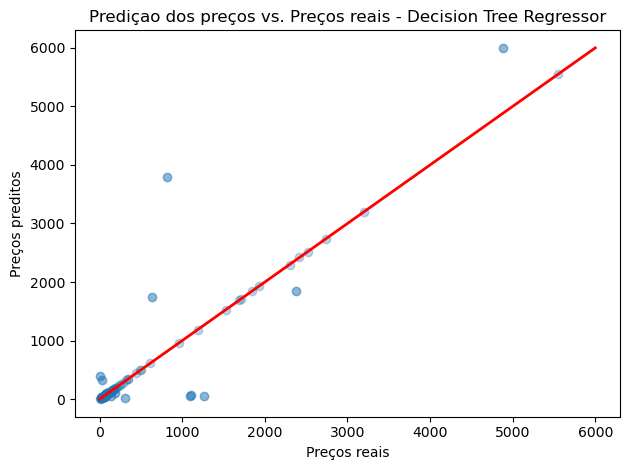

In [54]:
## Modelo de decision tree
tree_reg= DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_reg.fit(X_train, y_train)
price_pred2 = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, price_pred2)
tree_rmse= np.sqrt(tree_mse)
print('\nErro quadrático médio:', tree_rmse) 
# O erro quadrático médio já é consideravelmente menor do que o apresentado pela regressão linear, sendo um modelo um pouco melhor.
# Dessa vez, sendo apresentada uma diferença média de $505 dolares entre os preços reais e os preços preditos.

#Cross-validation: Decision Tree Regressor
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
print('\n', 'RMSE tree reg:',tree_rmse_scores)
tree_r2 = r2_score(y_test, price_pred2)
print('\n', 'R2 tree reg:',tree_r2)
# Novamente, o R2 do modelo de árvore de decisão é um pouco melhor do que do modelo anterior, sendo cerca de 74,25%. O que não é o melhor resultado, mas já é uma melhora considerável.

#Scatter plot: predições de preços vs. preços reais - Regressão de Árvore de decisão
plt.scatter(x=y_test, y=price_pred2, alpha=0.3)
plt.title('Prediçao dos preços vs. Preços reais - Decision Tree Regressor')
plt.xlabel('Preços reais')
plt.ylabel('Preços preditos')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color= 'red', lw=2)
plt.tight_layout()
plt.show()
# O gráfico mostra que a Decision Tree Regressor consegue predizer alguns valores no eixo esperado, mas ainda há algumas predições fora do eixo.


Erro quadrático médio: 546.0890421905896

 RMSE random forest reg: [459.86632833 420.50373475 413.05288882 943.31591275 451.73032057
 361.45752895 443.86532631 574.19030086 373.46783353 688.32340791]

 R2 random forest reg: 0.6997440079350592


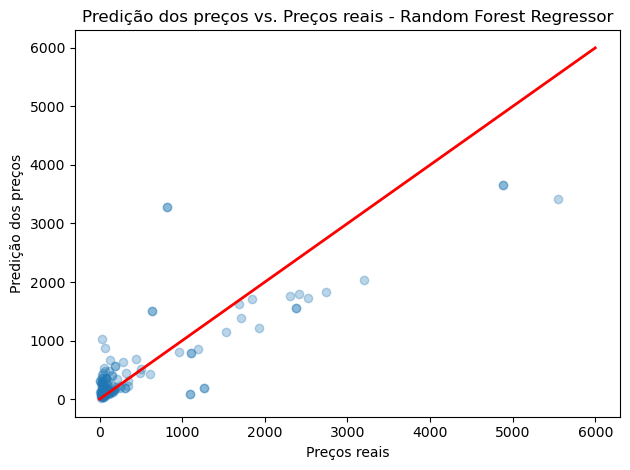

In [55]:
## Modelo de random forest regressor
rdmf_reg = RandomForestRegressor(random_state=RANDOM_STATE)
rdmf_reg.fit(X_train, y_train)
price_pred3 = rdmf_reg.predict(X_test)
rdmf_mse = mean_squared_error(y_test, price_pred3)
rdmf_rmse = np.sqrt(rdmf_mse)
print('\nErro quadrático médio:', rdmf_rmse) 
# O erro quadrático médio é de $546 dolares.
# É um erro um pouco maior do que o da decision tree mas ainda bem menor do que o da regressão linear, sendo um modelo que fica entre o meio termo, mais pro lado da Decision Tree.

#Cross-validation: Random Forest Regressor
rdmf_scores = cross_val_score(rdmf_reg,X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rdmf_rmse_scores= np.sqrt(-rdmf_scores)
print('\n', 'RMSE random forest reg:',rdmf_rmse_scores)
rdmf_r2 = r2_score(y_test, price_pred3)
print('\n', 'R2 random forest reg:',rdmf_r2)
# O R2 do modelo de Random Forest Regressor é de 69,97%, o que é um resultado um pouco pior do que o da Decision Tree, mas ainda assim, um resultado bom.

#Scatter plot: predições dos preçps vs. preços reais - Random Forest Regressor
plt.scatter(x=y_test, y=price_pred3, alpha=0.3)
plt.title("Predição dos preços vs. Preços reais - Random Forest Regressor")
plt.xlabel('Preços reais')
plt.ylabel('Predição dos preços')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)
plt.tight_layout()
plt.show()
# O gráfico mostra que o modelo de Random Forest Regressor preve alguns valores no eixo esperado, mas tem uma maior dificuldade em predizer os produtos que de fato teriam um valor maior.


Aperfeiçoamento do modelo

In [ ]:
#Aperfeiçoando o modelo com GridSearchCV
param_grid= {'max_depth': [3, 5,8,10, 12, None],
     'min_samples_split': [2, 5,10],
     'min_samples_leaf': [1,2,4],
     'max_features': [None, 'sqrt', 'log2']
     }
cv= KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=tree_reg, param_grid= param_grid, cv=cv,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)
grid_search.fit(X_train, y_train)

print('\n','Melhores hiperparametros encontrados:',grid_search.best_params_)
print('\n','Melhor modelo treinado:',grid_search.best_estimator_)

final_model_gs = grid_search.best_estimator_
final_model_gs.fit(X_train, y_train)
final_model_gs_price_pred = final_model_gs.predict(X_test)
final_model_gs_mse = mean_squared_error(y_test, final_model_gs_price_pred)
final_model_gs_rmse = np.sqrt(final_model_gs_mse)
print('\n', 'Final model GS RMSE:',final_model_gs_rmse)
final_model_gs_r2 = r2_score(y_test, final_model_gs_price_pred)
print('\n', 'Final model GS R2:',final_model_gs_r2)
# O modelo de Decision Tree Regressor com GridSearchCV teve um erro quadrático médio de $526 dólares e um R2 de 72%, indicando que o modelo treinado sem o GridSearch operou melhor
# do que o modelo treinado com o GridSearch, mesmo com os melhores hiperparâmetros encontrados, evidenciando que os melhores hiperparametros não necessariamente são os que vão gerar o melhor modelo.



 Melhores hiperparametros encontrados: {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

 Melhor modelo treinado: DecisionTreeRegressor(max_depth=12, random_state=42)

 Final model GS RMSE: 526.7846352793642

 Final model GS R2: 0.7205970688818222


In [66]:
#Aperfeiçoando o modelo com RandomSearchCV
param_rdm_search = {'max_depth': [3, 5,8,10, 12, None],
     'min_samples_split': [2, 5,10],
     'min_samples_leaf': [1,2,4],
     'max_features': [None, 'sqrt', 'log2']
     }

random_search = RandomizedSearchCV(tree_reg, param_distributions=param_rdm_search,
                                   n_iter=10,
                                   cv=cv,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1,
                                   return_train_score=True,
                                   random_state= RANDOM_STATE)
random_search.fit(X_train, y_train)
print('\n','Melhores hiperparametros encontrados:',random_search.best_params_)
print('\n','Melhor modelo treinado:',random_search.best_estimator_)
final_model_rdm = random_search.best_estimator_
final_model_rdm.fit(X_train, y_train)
final_model_rdm_price_pred = final_model_rdm.predict(X_test)
final_model_rdm_mse = mean_squared_error(y_test, final_model_rdm_price_pred)
final_model_rdm_rmse = np.sqrt(final_model_rdm_mse)
print('\n', 'Final model RDM RMSE:',final_model_rdm_rmse)
final_model_rdm_r2 = r2_score(y_test, final_model_rdm_price_pred)
print('\n', 'Final model RDM R2:',final_model_rdm_r2)

# O refinamento com Random SearchCV teve um erro quadrático médio de $773 dólares e um R2 de 39,80%. Assim, indicando que o modelo treiando com o RandomSearch não foi bom.
# O que mostra que o modelo de Decision Tree Regressor treinado sem nenhum aperfeiçoamento foi o melhor modelo entre os três modelos testados e mesmo comparado com o próprio aperefeiçoado.


 Melhores hiperparametros encontrados: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

 Melhor modelo treinado: DecisionTreeRegressor(max_features='sqrt', random_state=42)

 Final model RDM RMSE: 773.2566459594717

 Final model RDM R2: 0.39797838881225367


Comparando os resultados obtidos com o GridSearchCV e com o RandomSearchCV

In [ ]:
#Comparação do tempo de execução
start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()
print(f"Tempo de execução do GridSearchCV: {end - start:.2f} segundos")

start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
print(f"Tempo de execução do RandomizedSearchCV: {end - start:.2f} segundos")

#O tempo de execução do Random Search foi bem mais rápido do que o tempo do GridSearch, no entanto foi possível perceber que o ganho com um tempo menor muito provavelmente não seria um ponto de decisão para usar o modelo identificado pelo RSearch,
# já que o modelo do GSearch teve parametros melhores entre os dois.

Tempo de execução do GridSearchCV: 0.75 segundos
Tempo de execução do RandomizedSearchCV: 0.06 segundos


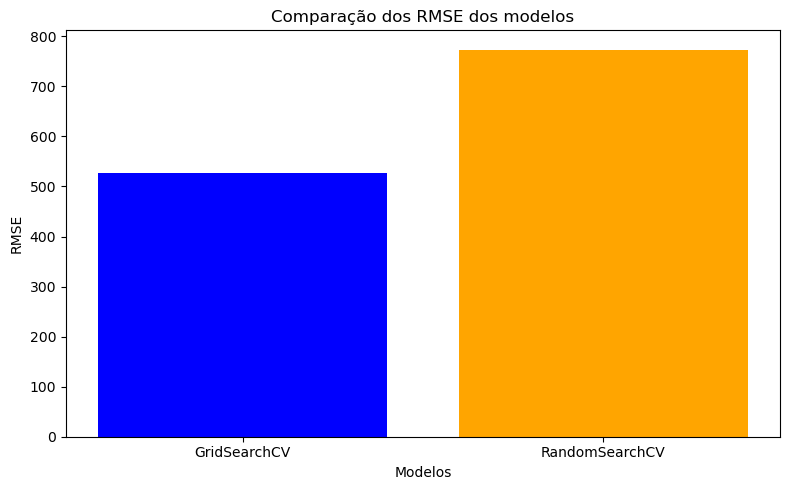

In [72]:
#Visualização dos resultados RMSE
plt.figure(figsize=(8,5))
plt.bar(['GridSearchCV', 'RandomSearchCV'], [final_model_gs_rmse, final_model_rdm_rmse],color = ['blue', 'orange'])
plt.title('Comparação dos RMSE dos modelos')
plt.ylabel('RMSE')
plt.xlabel('Modelos')
plt.tight_layout() 
plt.show()

# O gráfico representada a comparação visual dos erros médios quadráticos dos modelos de aperfeiçoamento, evidenciando um menor RMSE para o GridSearch do que para o RandomSearch.
# O que mostra que o modelo de Decision Tree Regressor treinado com o GridSearchCV teve um desempenho melhor do que o modelo treinado com o RandomSearchCV.


In [ ]:
#Comparação dos scores de treino e validação	
mean_train_score_gs = np.mean(grid_search.cv_results_['mean_train_score'])
mean_val_score_gs = np.mean(grid_search.cv_results_['mean_test_score'])
mean_train_score_rdm = np.mean(random_search.cv_results_['mean_train_score'])
mean_val_score_rdm = np.mean(random_search.cv_results_['mean_test_score'])

print('\n','GridSearchCV - Média de treino:',mean_train_score_gs)
print('\n','GridSearchCV - Média de validação:',mean_val_score_gs)
print('\n','RandomSearchCV - Média de treino:',mean_train_score_rdm)
print('\n','RandomSearchCV - Média de validação:',mean_val_score_rdm)

#As médias de avaliação são apresentadas em neg_mean_squared_error, onde quanto menor o valor, melhor o modelo.
# Dessa forma, o modelo de GridSearch teve médias piores do que o modelo de RandomSearch, apesar de apresentar um melhor modelo no final.
# Isso pode signficar que o modelo de GridSearch, por testar todos os modelos possíveis, a média foi puxada para baixo, enquanto o modelo de RandomSearch, por testar menos modelos, teve uma média melhor.


 GridSearchCV - Média de treino: -357797.7327319858

 GridSearchCV - Média de validação: -680290.92590402

 RandomSearchCV - Média de treino: -265788.57530962926

 RandomSearchCV - Média de validação: -639175.9819687327


Salvar modelos com Joblib

In [ ]:
#modelo regressão linear 
joblib.dump(lin_reg, 'lin_reg_model.pkl')
#modelo decision tree   
joblib.dump(tree_reg, 'tree_reg_model.pkl')
#modelo random forest
joblib.dump(rdmf_reg, 'rdmf_reg_model.pkl')
#modelo grid search
joblib.dump(final_model_gs, 'final_model_gs.pkl')
#modelo random search
joblib.dump(final_model_rdm, 'final_model_rdm.pkl')

['final_model_rdm.pkl']

### Conclusão
O dataset analisado apresenta parametros pouco relacionais entre si. No entanto, é importante entender como dados assim servem de base na construção de modelos de regressão em Machine Learning, nesse caso, foram testados os modelos de linear regressor, decision tree regressor e random forest regressor. Além disso, o modelo que apresentou um melhor desempenho também foi aperfeiçoado usando tanto o Grid Search como o Random Search para entender se a busca por melhores hiperparametros seria eficiente.

Assim, foi possível perceber que o modelo de Árvore de Decisão foi o que apresentou o melhor desempenho em prever o preço dos produtos baseado nos diferntes parametros de avaliação, apresentando um menor erro quadrático médio (cerca de $505 dólares) e um maior R2 (cerca de 74,25% de acerto).

Porém, quando foi feito o aperfeiçoamento desse modelo com Grid Search (RMSE: 526; R2: 72%) e com Random Search (RMSE: 773; R2:39,80%), ambos os métodos apresentaram um desempenho final menor do que o modelo sem nenhum aperfeiçoamento. Por fim, o GSearch obteve uma média de scores pior do que o RSearch, o que pode ser justificado pela quantidade de modelos avaliados por cada método. 